In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(112, 35)


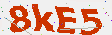

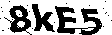

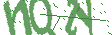

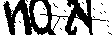

In [2]:
from captchagen import get_captcha_image, generate_captcha, preprocess_image
# 示例使用
image, cookie = get_captcha_image()

# image info
print(image.size)
# show image
from IPython.display import display

display(image)
display(preprocess_image(image))

image, captcha = generate_captcha()
display(image)
display(preprocess_image(image))

In [6]:
import torch
from models.cnn import CaptchaOCR
model = CaptchaOCR().to(device)
import os

if os.path.exists("captcha_ocr.pth"):
    model.load_state_dict(torch.load("captcha_ocr.pth"))

/tmp/ipykernel_1056577/1488443610.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("captcha_ocr.pth"))


In [3]:
from models.transformer import CaptchaSolverWithTransformer
model = CaptchaSolverWithTransformer().to(device)
import os

if os.path.exists("captcha_transformer.pth"):
    model.load_state_dict(torch.load("captcha_transformer.pth"))

/home/caoziguang/miniconda3/envs/captcha/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_1203494/4085151542.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed t

In [13]:
from models.cnn_transformer import CaptchaSolverWithCNNTransformer

model = CaptchaSolverWithCNNTransformer().to(device)
import os

# if os.path.exists("captcha_cnn_transformer.pth"):
#     model.load_state_dict(torch.load("captcha_cnn_transformer.pth"))

/home/cao/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [66]:
from models.resnet import ResNetCaptchaOCR

model = ResNetCaptchaOCR().to(device)
import os

if os.path.exists("captcha_resnet.pth"):
    model.load_state_dict(torch.load("captcha_resnet.pth"))

In [57]:
# save model
def save_model(model):
    if model.__class__.__name__ == "CaptchaOCR":
        torch.save(model.state_dict(), "captcha_ocr.pth")
    elif model.__class__.__name__ == "CaptchaSolverWithTransformer":
        torch.save(model.state_dict(), "captcha_transformer.pth")
    elif model.__class__.__name__ == "ResNetCaptchaOCR":
        torch.save(model.state_dict(), "captcha_resnet.pth")

In [46]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/{model.__class__.__name__}")
last_epoch = 0

In [63]:
from torch.utils.data import DataLoader
from dataset import CaptchaDataset

dataset = CaptchaDataset(10000,repeat=8)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = CaptchaDataset(250)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)


100%|██████████| 250/250 [00:00<00:00, 328.34it/s]


In [71]:
# train model
import torch
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(last_epoch, 100+last_epoch):
    last_epoch = epoch
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean()
    tqdm.write(f"epoch: {epoch}, loss: {loss.item()}, accuracy: {accuracy.item()}")

    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            total_loss += criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1)).item()
            total_accuracy += (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
        total_loss /= len(test_dataloader)
        tqdm.write(f"test loss: {total_loss}, test accuracy: {total_accuracy / len(test_dataloader)}")
    writer.add_scalars("loss", {
        "train": loss.item(),
        "test": total_loss
    }, epoch)
    writer.add_scalars("accuracy", {
        "train": accuracy.item(),
        "test": total_accuracy / len(test_dataloader)
    }, epoch)
    save_model(model)
    

  0%|          | 0/312 [00:00<?, ?it/s]

100%|██████████| 312/312 [03:24<00:00,  1.53it/s]


epoch: 181, loss: 4.1007819175720215, accuracy: 0.0390625
test loss: 4.1385659490312845, test accuracy: 0.027901785714285716


100%|██████████| 312/312 [02:51<00:00,  1.82it/s]


epoch: 182, loss: 4.0031418800354, accuracy: 0.0546875
test loss: 4.1125552994864325, test accuracy: 0.027901785714285716


100%|██████████| 312/312 [02:41<00:00,  1.93it/s]


epoch: 183, loss: 3.990255832672119, accuracy: 0.0234375
test loss: 4.109961986541748, test accuracy: 0.026785714285714284


100%|██████████| 312/312 [02:23<00:00,  2.17it/s]


epoch: 184, loss: 4.042577266693115, accuracy: 0.03125
test loss: 4.086356367383685, test accuracy: 0.029017857142857144


100%|██████████| 312/312 [02:31<00:00,  2.06it/s]


epoch: 185, loss: 3.9522340297698975, accuracy: 0.0390625
test loss: 4.051772015435355, test accuracy: 0.041294642857142856


100%|██████████| 312/312 [02:31<00:00,  2.05it/s]


epoch: 186, loss: 3.794245481491089, accuracy: 0.09375
test loss: 4.03539320400783, test accuracy: 0.03125


  6%|▌         | 19/312 [00:08<02:25,  2.02it/s]

In [30]:
# eval model
from dataset import CaptchaDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

test_dataset = CaptchaDataset(1000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

with torch.no_grad():
    total_loss = 0
    total_accuracy = 0
    for x, y in tqdm(test_dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        total_loss += criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1)).item()
        total_accuracy += (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
    total_loss /= len(test_dataloader)
    print(f"Loss: {total_loss/len(test_dataloader)} Accuracy: {total_accuracy/len(test_dataloader)}")

100%|██████████| 31/31 [00:00<00:00, 718.47it/s]

Loss: 0.030414240355298126 Accuracy: 0.7046370967741935


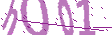

hQo1


[('n87Y', 9.280781654297243e-08),
 ('n8mY', 9.125150057798237e-08),
 ('n8sY', 9.088097385756555e-08),
 ('J87Y', 9.087982988376098e-08),
 ('nc7Y', 9.080554264073726e-08),
 ('787Y', 9.056894612058386e-08),
 ('n87u', 9.040382309422057e-08),
 ('n83Y', 9.036206449763995e-08),
 ('n8DY', 9.031220571387166e-08),
 ('n8JY', 9.002723544426772e-08)]

In [67]:
from captchagen import generate_captcha, preprocess_image
from torchvision import transforms
# test model
image, captcha = generate_captcha()
display(image)
print(captcha)
image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
y_pred

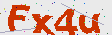

[('P4dG', 6.923270575498464e-06),
 ('P44G', 6.065429715818027e-06),
 ('PddG', 5.4924707910686266e-06),
 ('P4d3', 5.471089025377296e-06),
 ('H4dG', 5.4138868108566385e-06),
 ('PcdG', 5.277231139189098e-06),
 ('P4dq', 5.127371878188569e-06),
 ('P3dG', 5.079692073195474e-06),
 ('P4FG', 4.959315447194967e-06),
 ('PxdG', 4.918065769743407e-06)]

In [60]:
from captchagen import get_captcha_image
# test model on real captcha
image, cookie = get_captcha_image()
display(image)

image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
y_pred